<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#分析LTEPAT输出结果" data-toc-modified-id="分析LTEPAT输出结果-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>分析LTEPAT输出结果</a></span><ul class="toc-item"><li><span><a href="#导入相关程序库" data-toc-modified-id="导入相关程序库-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>导入相关程序库</a></span></li><li><span><a href="#读取文件" data-toc-modified-id="读取文件-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>读取文件</a></span></li><li><span><a href="#用字典形式存储所有KPI-counter的ID和对应的名字" data-toc-modified-id="用字典形式存储所有KPI-counter的ID和对应的名字-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>用字典形式存储所有KPI counter的ID和对应的名字</a></span></li><li><span><a href="#分析Excel中指定Sheet的数据" data-toc-modified-id="分析Excel中指定Sheet的数据-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>分析Excel中指定Sheet的数据</a></span><ul class="toc-item"><li><span><a href="#读取执行sheet的数据" data-toc-modified-id="读取执行sheet的数据-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>读取执行sheet的数据</a></span></li><li><span><a href="#整理sheet数据" data-toc-modified-id="整理sheet数据-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>整理sheet数据</a></span></li><li><span><a href="#抽取sheet中指定的列" data-toc-modified-id="抽取sheet中指定的列-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>抽取sheet中指定的列</a></span></li><li><span><a href="#对指定数据进行可视化" data-toc-modified-id="对指定数据进行可视化-1.4.4"><span class="toc-item-num">1.4.4&nbsp;&nbsp;</span>对指定数据进行可视化</a></span></li></ul></li></ul></li></ul></div>

### 分析LTEPAT输出结果

#### 导入相关程序库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### 读取文件

In [2]:
# 这里的excel文件是LTEPAT处理eNB Snapshot中的PM文件后的输出文件
file_path = r"D:\userdata\anliu\Desktop\log\IRAN\Snapshot_MRBTS-361641"
file_name = r"201809071240_PMOutput.xlsx"

os.chdir(file_path)

file = os.path.join(file_path, file_name)
xls = pd.ExcelFile(file)

#### 用字典形式存储所有KPI counter的ID和对应的名字

In [3]:
def get_counter_name(xls):
    counters = {}
    for sheet in xls.sheet_names:
        if not sheet.startswith('KPI') and not sheet.startswith('Summary') :
            sheet_data = xls.parse(sheet)
            sheet_data.dropna(how='all', axis=1, inplace=True)
            sheet_data.dropna(how='all', axis=0, inplace=True)            
            sheet_cols = sheet_data.columns.tolist()[4:]
            
            for col in sheet_cols:
                cid = col.split(':')[0]
                name = col.split(':')[1]
                counters[cid] = name

    return counters

counters = get_counter_name(xls)

# 将字典内容写入到文件
# outfile = r"D:\userdata\anliu\Desktop\log\IRAN\Snapshot_MRBTS-371324\test.txt"
# with open(outfile, 'w+') as out:
#     for key in counters:
#         out.writelines((key + ',' + counters[key] + '\n'))

#### 分析Excel中指定Sheet的数据

##### 读取执行sheet的数据

In [4]:
sheet_name = 'LTE_Pwr_and_Qual_UL'
# ExcelFile.parse(sheet_name=0, header=0, skiprows=None, skip_footer=0, names=None, index_col=None, 
#                 usecols=None, parse_dates=False, date_parser=None, na_values=None, thousands=None, 
#                 convert_float=True, converters=None, true_values=None, false_values=None, squeeze=False, **kwds)
# 每张Sheet中后面5行数据是统计数据，不需要
data = xls.parse(sheet_name, skipfooter=5)

##### 整理sheet数据

In [5]:
def data_clean_up(data):
    # 去掉所有值是NAN的行和列
    data.dropna(how='all', axis=1, inplace=True)
    data.dropna(how='all', axis=0, inplace=True)
    # 合并Date和Time列并转化为datetime格式
    Time = data.StartDate.astype(str) + ' ' + data.StartTime.astype(str)
    data['Time'] = pd.to_datetime(Time)
    data.drop(axis=1, columns=['StartDate', 'StartTime'], inplace=True)
    # 将新生成的Time列置为第1列
    cols = data.columns.tolist()
    cols = cols[-1:] + cols[0:-1]
    data = data[cols]
    
    return data

data = data_clean_up(data)

##### 抽取sheet中指定的列

In [6]:
iot = [
       'M8005C317:UL_IOT_PUSCH_DIST_BIN_0 (1.0E-1 dB)', 'M8005C318:UL_IOT_PUSCH_DIST_BIN_1 (1.0E-1 dB)',
       'M8005C319:UL_IOT_PUSCH_DIST_BIN_2 (1.0E-1 dB)', 'M8005C320:UL_IOT_PUSCH_DIST_BIN_3 (1.0E-1 dB)',
       'M8005C321:UL_IOT_PUSCH_DIST_BIN_4 (1.0E-1 dB)', 'M8005C322:UL_IOT_PUSCH_DIST_BIN_5 (1.0E-1 dB)',
       'M8005C323:UL_IOT_PUSCH_DIST_BIN_6 (1.0E-1 dB)', 'M8005C324:UL_IOT_PUSCH_DIST_BIN_7 (1.0E-1 dB)',
       'M8005C325:UL_IOT_PUSCH_DIST_BIN_8 (1.0E-1 dB)', 
#        'M8005C233:RSSI_CELL_PUSCH_MEAN (dBm)', 'M8005C283:SINR_CELL_PUSCH_MEAN (dB)'
      ]

# 仅保留需要处理的columns
def data_crop(data, cols):
    data_crop = pd.concat([data[['Time', 'baseId', 'localMoid']], data[cols]], axis=1)
    
    return data_crop

data_iot = data_crop(data, iot)

##### 对指定数据进行可视化

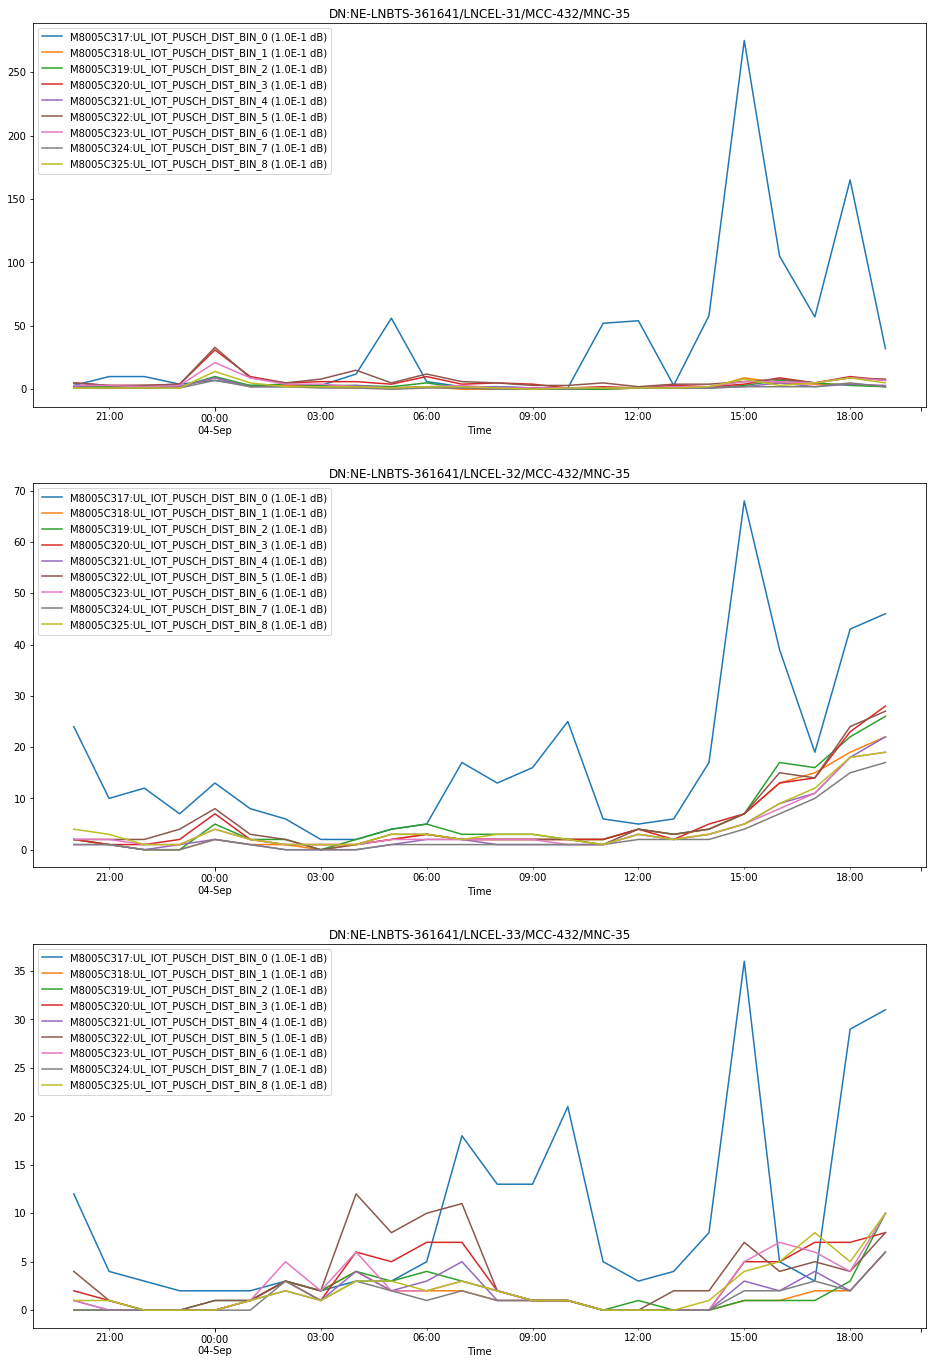

In [7]:
def visual_data(data):
    grouped_by_cell = data.groupby('localMoid')
    # grouped_by_cell.plot(x='Time', y=data_iot.columns[3:12], kind="line", figsize=(16,8))
    fig = plt.figure(figsize=(16,24))
    n = len(grouped_by_cell)
    for i, (name, group) in enumerate(grouped_by_cell):
        ax = fig.add_subplot(n, 1, i+1)
        group.plot(x='Time', y=group.columns[3:], ax=ax, title=name)    
#         days = mdates.DayLocator(interval=1)
#         hours = mdates.HourLocator(interval=6)
#         ax.xaxis.set_major_locator(days)
#         ax.xaxis.set_minor_locator(hours)
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
#         ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
#         ax.tick_params(pad=10)
#         ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.3))
        ax.xaxis.set_label_coords(0.5, -0.05)
    plt.savefig('IoT.jpg')
    
visual_data(data_iot)

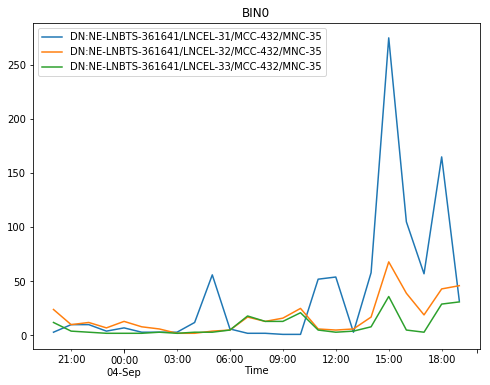

In [8]:
# 比较不同localMoid的同一列数据
grouped_by_cell = data_iot.groupby('localMoid')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for i, (name, group) in enumerate(grouped_by_cell):
    group.plot(x='Time', y=group.columns[3], ax=ax, title='BIN0', label=name)
    ax.xaxis.set_label_coords(0.5, -0.05)